In [ ]:
! pip install numpy,tensorflow,matplotlib,tqdm

In [1]:
from Gridworld import Gridworld
from tensorflow import keras
import numpy as np
from matplotlib import pylab as plt
import random
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

In [4]:
tst_game = Gridworld(size=4, mode='static')
print("statue:\n",tst_game.board.render_np())
tst_game.makeMove('d')
print("new statue:\n",tst_game.board.render_np())
print("reward:",tst_game.reward())
print("shape of board:",tst_game.board.render_np().shape)

statue:
 [[[0 0 0 1]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
new statue:
 [[[0 0 0 0]
  [0 0 0 1]
  [0 0 0 0]
  [0 0 0 0]]

 [[1 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 1 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
reward: -1
shape of board: (4, 4, 4)


In [4]:
model = keras.Sequential([
    keras.layers.Dense(150, input_dim= 64,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(4,activation="linear")
])
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn)



In [8]:
import tensorflow as tf
from tqdm import tqdm
banch_size=200
memory_size=1000
fit_banch_size=32
memory_list = []
def memory_train(memory:list,gamma:float):
      train_data = random.sample(memory,banch_size)
      Y = []
      X = []
      # print("train_data:",train_data)
      for state1,action,reward,state2,isdone in train_data:
            full_q1 = model.predict(state1,verbose=0)[0]
            # print("full_q1:",full_q1)
            # print("action:",action)
            q2 = max(model.predict(state2,verbose=0)[0])
            if isdone:
                  target = reward
            else:
                  target = reward + gamma * q2
            full_q1[action] = target
            Y.append(full_q1)
            X.append(state1[0])
      X = np.array(X)
      Y = np.array(Y)
      # print("X.shape:",X.shape,"Y.shape:",Y.shape)
      # print("X:",np.isnan(X).any(),"Y:",np.isnan(Y).any())
      history = model.fit(X,Y,batch_size=fit_banch_size,epochs=10)
      return history

def train(gamma:float = 0.9,first_epsilon:int=1,final_epsilon:int=0.1,
          epochs:int=5000,max_steps:int=100,env_model:str='static'):
      epsilon = first_epsilon
      loss_list = []
      for ep in tqdm(range(epochs)):
            env = Gridworld(size=4, mode=env_model)
            state1 = env.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
            # state1 = tf.convert_to_tensor(_state1)
            # print("state1:",state1,"state1.shape:",state1.shape)
            
            isdone = False
            for move in range(max_steps):
                  qval = model.predict(state1,verbose=0)[0]
                  if random.random() < epsilon:
                        _action = np.random.randint(0,4)
                  else:
                        _action = np.argmax(qval)
                  action = action_set[_action]
                  env.makeMove(action)
                  state2 = env.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 100.0
                  # state2 = tf.convert_to_tensor(_state2)
                  reward = env.reward()
                  if reward != -1:
                        isdone = True
                  experience = [state1, _action, reward, state2, isdone]
                  memory_list.append(experience)
                  state1 = state2
                  if len(memory_list) > memory_size:
                        
                        loss_history = memory_train(memory_list,gamma).history["loss"]
                        print("loss:",loss_history[-1])
                        loss_list.extend(loss_history)
                        memory_list.clear()
                  if isdone:
                        break
            if epsilon > final_epsilon:
                  epsilon -= (first_epsilon - final_epsilon) / epochs
                  # print("\repsilon:",epsilon)
      return loss_list

In [9]:
losses = train(epochs=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

  3%|▎         | 30/1000 [02:17<1:25:23,  5.28s/it]

Epoch 1/10
7/7 [==============================] - 2s 18ms/step - loss: 0.4692
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4372
Epoch 3/10
7/7 [==============================] - 0s 6ms/step - loss: 0.4156
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 0.3965
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.3802
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.3660
Epoch 7/10
7/7 [==============================] - 0s 6ms/step - loss: 0.3565
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.3491
Epoch 9/10
7/7 [==============================] - 0s 9ms/step - loss: 0.3382
Epoch 10/10
7/7 [==============================] - 0s 9ms/step - loss: 0.3243
loss: 0.32429856061935425


  6%|▌         | 62/1000 [06:06<2:30:15,  9.61s/it]

Epoch 1/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2044
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.1911
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.1855
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.1836
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.1749
Epoch 6/10
7/7 [==============================] - 0s 6ms/step - loss: 0.1727
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.1763
Epoch 8/10
7/7 [==============================] - 0s 9ms/step - loss: 0.1719
Epoch 9/10
7/7 [==============================] - 0s 12ms/step - loss: 0.1709
Epoch 10/10
7/7 [==============================] - 0s 10ms/step - loss: 0.1736
loss: 0.17362193763256073


 10%|▉         | 98/1000 [09:43<1:10:20,  4.68s/it]

Epoch 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.4179
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.3791
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 0.3287
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 0.3005
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2838
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2643
Epoch 7/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2486
Epoch 8/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2380
Epoch 9/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2388
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2350
loss: 0.23495720326900482


 13%|█▎        | 134/1000 [13:37<54:20,  3.77s/it]  

Epoch 1/10
7/7 [==============================] - 0s 4ms/step - loss: 0.5051
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4569
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4260
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.4024
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.3965
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3902
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3904
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3897
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3811
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.3828
loss: 0.3827798068523407


 16%|█▋        | 164/1000 [17:27<1:03:27,  4.55s/it]

Epoch 1/10
7/7 [==============================] - 0s 5ms/step - loss: 0.5473
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5050
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4654
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4376
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4313
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4256
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4260
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.4202
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4179
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4174
loss: 0.4174117147922516


 20%|██        | 203/1000 [21:14<39:58,  3.01s/it]  

Epoch 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.5419
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4794
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4561
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.4374
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4275
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.4134
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.4091
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4108
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4122
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.4070
loss: 0.4069834053516388


 24%|██▍       | 240/1000 [25:13<54:21,  4.29s/it]  

Epoch 1/10
7/7 [==============================] - 0s 4ms/step - loss: 0.8924
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7707
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7206
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6928
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6837
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6671
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6453
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6459
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6485
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6403
loss: 0.6402907371520996


 28%|██▊       | 281/1000 [28:29<39:45,  3.32s/it]  

Epoch 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.8625
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7825
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7266
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6942
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7203
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6818
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6658
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6937
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7190
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6983
loss: 0.6982583403587341


 32%|███▏      | 322/1000 [31:50<38:01,  3.37s/it]  

Epoch 1/10
7/7 [==============================] - 0s 5ms/step - loss: 0.8007
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7067
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7013
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6664
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6654
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6397
Epoch 7/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6404
Epoch 8/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6232
Epoch 9/10
7/7 [==============================] - 0s 8ms/step - loss: 0.6203
Epoch 10/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6320
loss: 0.6319624781608582


 36%|███▋      | 363/1000 [35:18<31:39,  2.98s/it]  

Epoch 1/10
7/7 [==============================] - 0s 8ms/step - loss: 0.7843
Epoch 2/10
7/7 [==============================] - 0s 10ms/step - loss: 0.7012
Epoch 3/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6897
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6437
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 0.6102
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6069
Epoch 7/10
7/7 [==============================] - 0s 10ms/step - loss: 0.5963
Epoch 8/10
7/7 [==============================] - 0s 11ms/step - loss: 0.5848
Epoch 9/10
7/7 [==============================] - 0s 13ms/step - loss: 0.5886
Epoch 10/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6109
loss: 0.6108781099319458


 42%|████▏     | 421/1000 [38:49<35:02,  3.63s/it]  

Epoch 1/10
7/7 [==============================] - 0s 6ms/step - loss: 1.1837
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 1.0371
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 1.0240
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.9646
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.9286
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.9197
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.9316
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.9232
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.9029
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.9012
loss: 0.9011982679367065


 49%|████▉     | 492/1000 [42:18<22:46,  2.69s/it]  

Epoch 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.8121
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 0.7378
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.6897
Epoch 4/10
7/7 [==============================] - 0s 10ms/step - loss: 0.6729
Epoch 5/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6578
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6577
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6513
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6450
Epoch 9/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6477
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6375


 49%|████▉     | 493/1000 [43:33<3:25:53, 24.37s/it]

loss: 0.6374728083610535


 56%|█████▋    | 565/1000 [46:08<10:56,  1.51s/it]  

Epoch 1/10
7/7 [==============================] - 0s 8ms/step - loss: 0.9574
Epoch 2/10
7/7 [==============================] - 0s 8ms/step - loss: 0.8703
Epoch 3/10
7/7 [==============================] - 0s 12ms/step - loss: 0.8083
Epoch 4/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7990
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7575
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7578
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.7522
Epoch 8/10
7/7 [==============================] - 0s 4ms/step - loss: 0.7524
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7702
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.7599
loss: 0.7599471211433411


 64%|██████▍   | 642/1000 [49:07<03:47,  1.58it/s]  

Epoch 1/10
7/7 [==============================] - 0s 2ms/step - loss: 1.0044
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.8650
Epoch 3/10
7/7 [==============================] - 0s 781us/step - loss: 0.8356
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.8259
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.8338
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.8223
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7989
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.8030
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7952
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7929
loss: 0.7929134964942932


 73%|███████▎  | 734/1000 [50:21<02:15,  1.96it/s]

Epoch 1/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7039
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6491
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6302
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6156
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6015
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6093
Epoch 7/10
7/7 [==============================] - 0s 341us/step - loss: 0.5964
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5890
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5983
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.5835
loss: 0.5835385322570801


 84%|████████▍ | 841/1000 [51:36<01:12,  2.19it/s]

Epoch 1/10
7/7 [==============================] - 0s 3ms/step - loss: 0.7292
Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6756
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6439
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6347
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6549
Epoch 6/10
7/7 [==============================] - 0s 923us/step - loss: 0.6270
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6399
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6291
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6315
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6178
loss: 0.6177789568901062


 96%|█████████▌| 959/1000 [52:51<00:18,  2.22it/s]

Epoch 1/10
7/7 [==============================] - 0s 4ms/step - loss: 0.6627
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6613
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6521
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6174
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.5993
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5990
Epoch 7/10
7/7 [==============================] - 0s 926us/step - loss: 0.6119
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.6087
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5956
Epoch 10/10
7/7 [==============================] - 0s 3ms/step - loss: 0.5840
loss: 0.5840029716491699


100%|██████████| 1000/1000 [53:30<00:00,  3.21s/it]


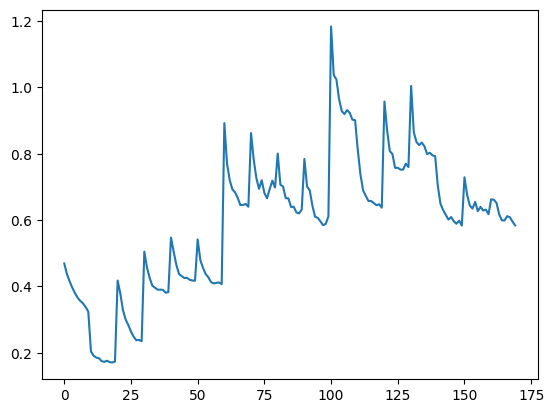

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [11]:
model.save('RL_dqn_gridworld_v2.h5')

In [2]:
from keras.models import load_model

# 載入模型
model = load_model('RL_dqn_gridworld_v2.h5')

In [3]:
def test():
    tst_env = Gridworld(size=4, mode='static')
    isdone = False
    for move in range(100):
        state1 = tst_env.board.render_np().reshape(1, 64)
        game_show = tst_env.display()
        print(move,":\n",game_show)
        qval = model.predict(state1,verbose=0)[0]
        _action = np.argmax(qval)
        action = action_set[_action]
        tst_env.makeMove(action)
        if tst_env.reward() != -1:
            isdone = True
        if isdone:
            break
    print("reward:",tst_env.reward())
    print("end:", tst_env.display())
test()

0 :
 [['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
1 :
 [['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
2 :
 [['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
3 :
 [['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
4 :
 [['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
5 :
 [['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
6 :
 [['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
reward: 10
end: [['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
